In [81]:
# load and optionally install required packages
if (!require('pacman')) install.packages('pacman')
pacman::p_load(
    caret,
    dplyr,
    readr,
    scales,
    stringr,
    tidyverse
)

In [82]:
results.raw <- read_csv('data/raw/mturk_results.csv')
scored_usernames.raw <- read_csv('data/raw/scored_twitter_usernames.csv')

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1365 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (21): HITId, HITTypeId, Title, Description, Keywords, Reward, CreationTi...
dbl  (4): MaxAssignments, AssignmentDurationInSeconds, AutoApprovalDelayInSe...
lgl  (6): NumberOfSimilarHITs, LifetimeInSeconds, RejectionTime, RequesterFe...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 683071 Columns: 10
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): username, checked

In [83]:
scored_usernames <- scored_usernames.raw %>%
select(
    username,
    cap_english,
    cap_universal,
    raw_english,
    raw_universal
)

In [93]:
summary <- results.raw %>%
filter(
    Answer.category.label != 'Account Does Not Exist'
)
summary.bot <- summary %>% filter(Answer.category.label == 'Likely Bot')
summary.human <- summary %>% filter(Answer.category.label == 'Likely Human')

print(paste('percent bot: ', percent(summary.bot %>% nrow() / summary %>% nrow())))
print(paste('percent human: ', percent(summary.human %>% nrow() / summary %>% nrow())))

[1] "percent bot:  26%"
[1] "percent human:  74%"


In [8]:
results.cleaned <- results.raw %>%
filter(
    Answer.category.label != 'Account Does Not Exist'
) %>%
mutate(
    username = str_extract(Input.url, '[\\w\\d]+/$'),
    username = substr(username, start = 1, stop = nchar(username) - 1),
    label = Answer.category.label
) %>%
select(
    username,
    label
)

In [29]:
results <- results.cleaned %>%
left_join(scored_usernames, by = 'username') %>%
filter(cap_english != -999) %>%
mutate(
    label = as.factor(label),
    cap_english = round(cap_english, digits = 2),
    cap_universal = round(cap_universal, digits = 2)
)

In [10]:
results.bot <- results %>%
filter(
    label == 'Likely Bot'
)
results.human <- results %>%
filter(
    label == 'Likely Human'
)

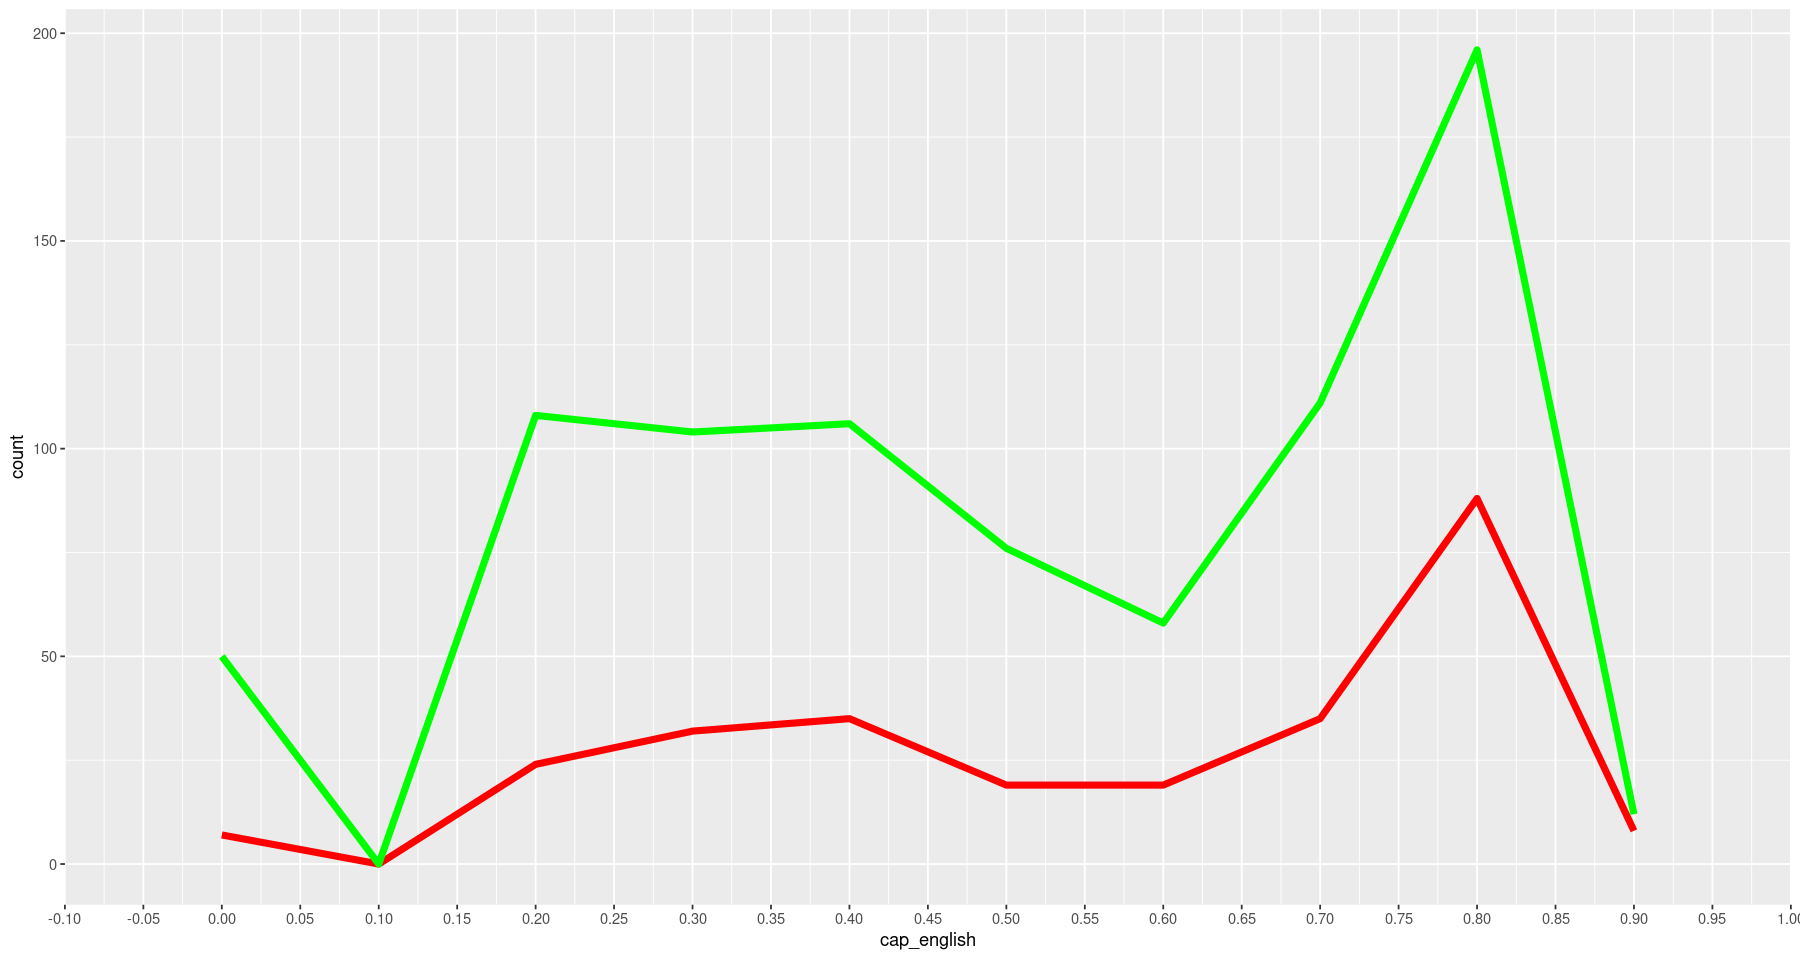

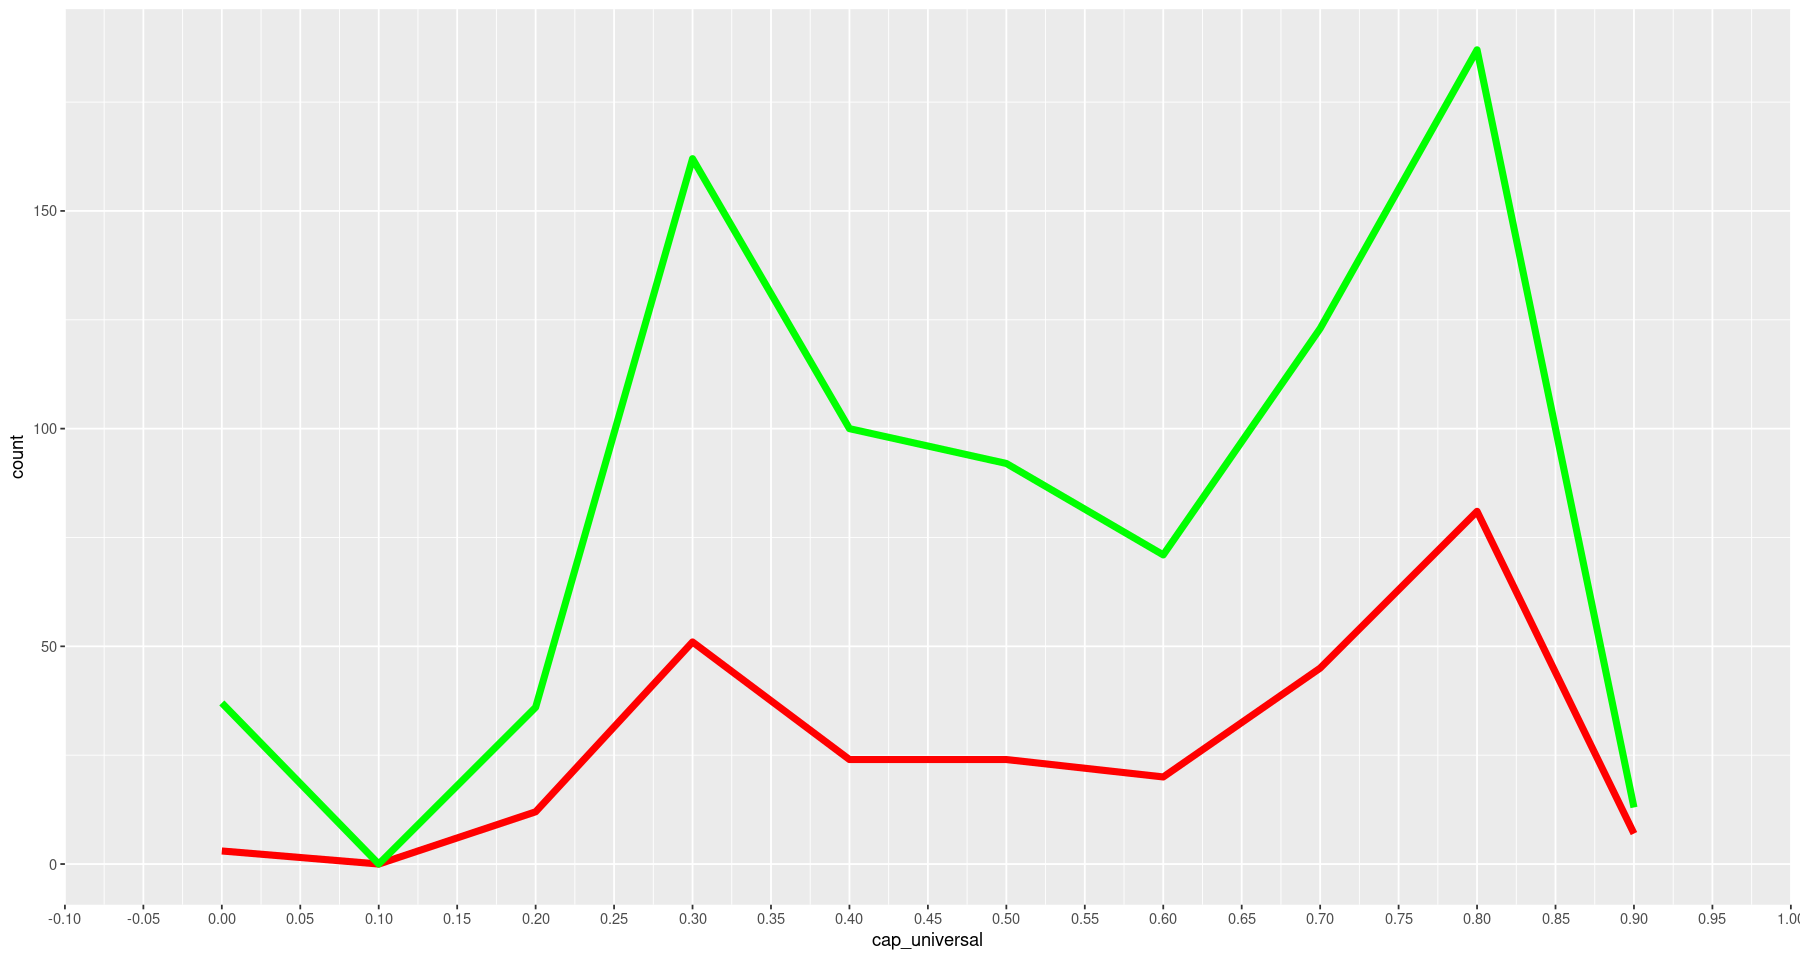

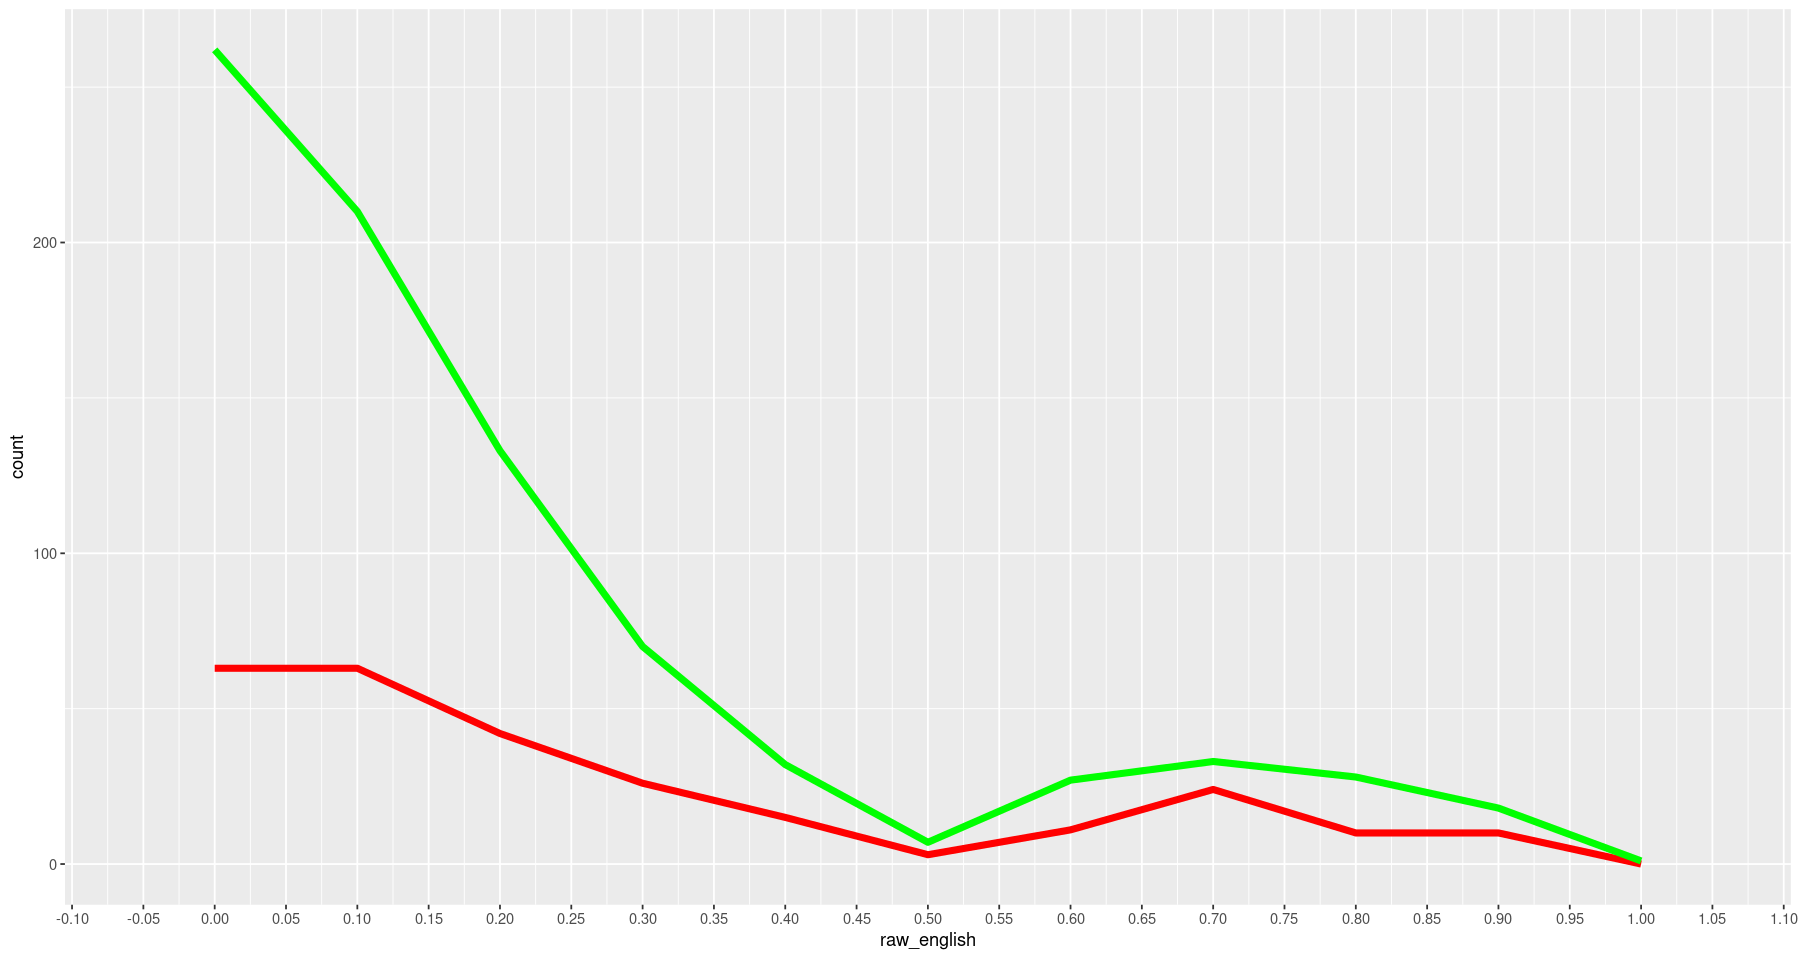

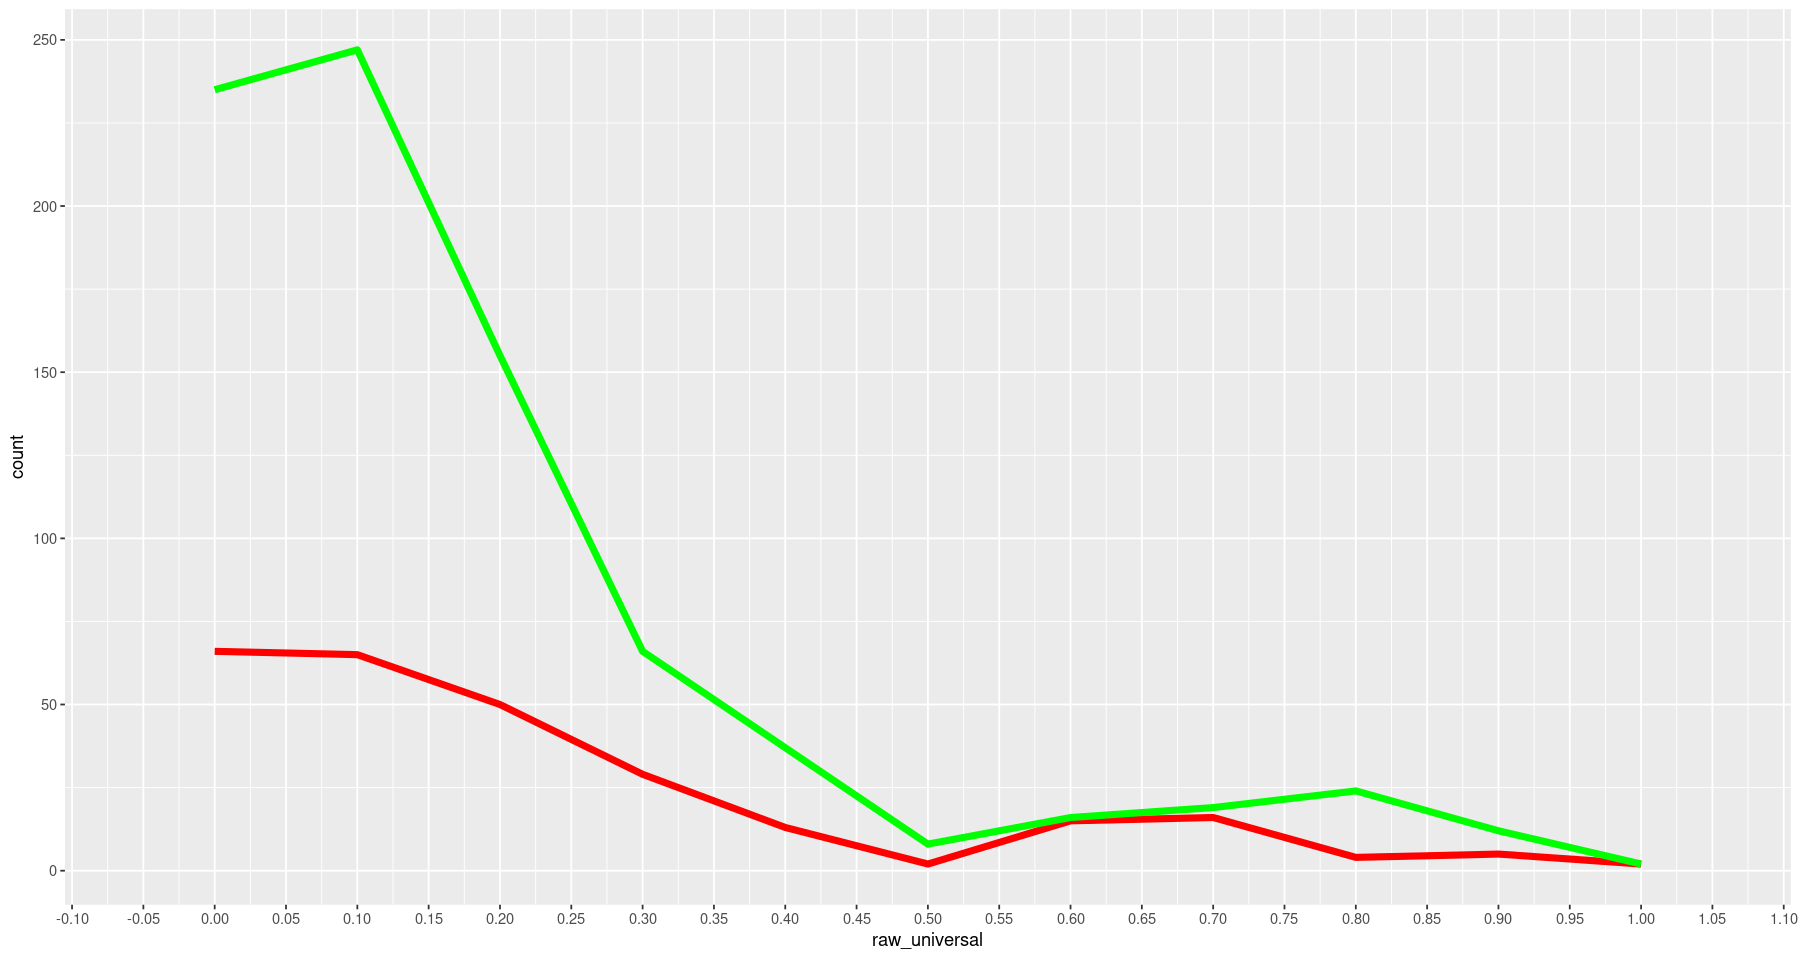

In [103]:
plot_scores <- function(metric){
    ggplot(
        data=NULL,
        aes(
            x = .data[[metric]]
        )
    ) +
    geom_line(data=results.bot, stat='bin', binwidth=0.1, color='red', size=2) +
    geom_line(data=results.human, stat='bin', binwidth=0.1, color='green', size=2) +
    scale_x_continuous(n.breaks = 20)
}

plot_scores("cap_english")
plot_scores("cap_universal")
plot_scores("raw_english")
plot_scores("raw_universal")

#options(repr.plot.width=15, repr.plot.height=8)

#geom_bar(data=results.bot, fill='red', width = 0.005) +
#geom_bar(data=results.human, fill='blue', width = 0.005, alpha=0.1)

In [71]:
cutoffs <- list();
accuracies <- list();
sensitivities <- list();
specificities <- list();

lapply(list(0.3, 0.35, 0.4, .45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1), function(cutoff_for_human){
    confusion_matrix_data <- results %>% mutate(
        predicted = as.factor(ifelse(raw_universal < cutoff_for_human, 'Likely Human', 'Likely Bot'))
    ) %>%
    select(
        label,
        predicted
    )
    confusion <- confusionMatrix(data = confusion_matrix_data$predicted, reference = confusion_matrix_data$label)
    print(paste('cutoff for human: ', cutoff_for_human))
    print(paste('accuracy: ', confusion$overall[['Accuracy']]))
    #print(paste('sensitivity: ', confusion$byClass[['Sensitivity']]))
    #print(paste('specificity: ', confusion$byClass[['Specificity']]))
    print('')
})

[1] "cutoff for human:  0.3"
[1] "accuracy:  0.685661764705882"
[1] ""
[1] "cutoff for human:  0.35"
[1] "accuracy:  0.693933823529412"
[1] ""
[1] "cutoff for human:  0.4"
[1] "accuracy:  0.715073529411765"
[1] ""
[1] "cutoff for human:  0.45"
[1] "accuracy:  0.71875"
[1] ""
[1] "cutoff for human:  0.5"
[1] "accuracy:  0.723345588235294"
[1] ""
[1] "cutoff for human:  0.55"
[1] "accuracy:  0.726102941176471"
[1] ""
[1] "cutoff for human:  0.6"
[1] "accuracy:  0.727022058823529"
[1] ""
[1] "cutoff for human:  0.65"
[1] "accuracy:  0.729779411764706"
[1] ""
[1] "cutoff for human:  0.7"
[1] "accuracy:  0.734375"
[1] ""
[1] "cutoff for human:  0.75"
[1] "accuracy:  0.729779411764706"
[1] ""
[1] "cutoff for human:  0.8"
[1] "accuracy:  0.739889705882353"
[1] ""
[1] "cutoff for human:  0.85"
[1] "accuracy:  0.745404411764706"
[1] ""
[1] "cutoff for human:  0.9"
[1] "accuracy:  0.748161764705882"
[1] ""
[1] "cutoff for human:  0.95"
[1] "accuracy:  0.750919117647059"
[1] ""


Warning message in confusionMatrix.default(data = confusion_matrix_data$predicted, :
“Levels are not in the same order for reference and data. Refactoring data to match.”


[1] "cutoff for human:  1"
[1] "accuracy:  0.754595588235294"
[1] ""


[[1]]
[1] ""

[[2]]
[1] ""

[[3]]
[1] ""

[[4]]
[1] ""

[[5]]
[1] ""

[[6]]
[1] ""

[[7]]
[1] ""

[[8]]
[1] ""

[[9]]
[1] ""

[[10]]
[1] ""

[[11]]
[1] ""

[[12]]
[1] ""

[[13]]
[1] ""

[[14]]
[1] ""

[[15]]
[1] ""

In [94]:
cutoff_for_human <- 0.3

calculate_confusion_matrix <- function(cutoff_for_human){
    confusion_matrix_data <- results %>% mutate(
        predicted = as.factor(ifelse(raw_universal < cutoff_for_human, 'Likely Human', 'Likely Bot'))
    ) %>%
    select(
        label,
        predicted
    )
    print(cutoff_for_human)
    confusionMatrix(data = confusion_matrix_data$predicted, reference = confusion_matrix_data$label)
}

calculate_confusion_matrix(cutoff_for_human);

## be more aggressive
## be ok with throwing out accounts that are human that we think are bots
## this is specificity

results.labeled <- results %>%
mutate(
    label = ifelse(raw_universal < cutoff_for_human, 'Likely Human', 'Likely Bot')
)

count.bots = results.labeled %>% filter(label == 'Likely Bot') %>% nrow();
count.humans = results.labeled %>% filter(label == 'Likely Human') %>% nrow();
count.total = results.labeled %>% nrow();

print(paste('percent bots:', percent(count.bots / count.total)))
print(paste('percent humans:', percent(count.humans / count.total)))

[1] 0.3


Confusion Matrix and Statistics

              Reference
Prediction     Likely Bot Likely Human
  Likely Bot           74          149
  Likely Human        193          672
                                          
               Accuracy : 0.6857          
                 95% CI : (0.6571, 0.7132)
    No Information Rate : 0.7546          
    P-Value [Acc > NIR] : 1.00000         
                                          
                  Kappa : 0.1013          
                                          
 Mcnemar's Test P-Value : 0.02006         
                                          
            Sensitivity : 0.27715         
            Specificity : 0.81851         
         Pos Pred Value : 0.33184         
         Neg Pred Value : 0.77688         
             Prevalence : 0.24540         
         Detection Rate : 0.06801         
   Detection Prevalence : 0.20496         
      Balanced Accuracy : 0.54783         
                                          
       'P

[1] "percent bots: 20%"
[1] "percent humans: 80%"
